# Tutorial 2- Optimal Control for Continuous State

Please execute the cell below to initialize the notebook environment.

In [1]:
import numpy as np                 # import numpy
import scipy               # import scipy
import random                      # import basic random number generator functions
from scipy.linalg import inv

import matplotlib.pyplot as plt    # import matplotlib

---

## Tutorial objectives

In this tutorial, we will implement the linear qudratic regulator (LQR) in 1D case.

---

## Quadratic cost function 

In general, a linear discrete-time system with noise has the dynamic:

\begin{equation*}
x_{t+1} = Dx_t + Ba_t + w_t 
\end{equation*}

with 

$x_t$: state at time $t$ 

$a_t$: control at time $t$

$w_t$: noise at time $t$

$D$ and $B$: parameters of the linear dynamical system  

For 1D case, $D$, $B$, $Q$, $R$ are all scalars.

In LQR problem,  a quadratic cost function is defined as: 

$$ J(x, a) = \sum_{t = 0}^{T-1} (Q x_{t}^2 + R a_{t}^2) + Q_T x_{T}^2$$

where $Q$ and $Q_N$ are the state cost matrices, and $R$ is the control cost matrix. 



The goal of the LQR problem is to find control $\{a_t\}_{t=0}^{T-1}$ such that $J(x, u)$ is minimized. For 1D case specially, the goal is then to find the control gain at each time point, i,.e.

$$ \text{argmin} _{K_t}  J(x, a) $$ 

where $a_t = K_t x_t$.

### Exercise 1: Control to the origin

In this exercise, we will use a time-invariant control to test the trajectory of the states and cost. 

For simplicity, we will apply the LQR control on a 1D case, where the matrices reduce to scalars, and the states, control and noise are one-dimensional as well. 

** Suggestions **
* In function `dynamics_zero_state( )`, complete the code for control *a*, and use that complete the dynamical updating function for state *x*.
* Set the controller gain to be a constant over time. You can play with this parameter to compare the dynamics and cost. 
* Compute the mean square error (MSE) of the states with control and the target states (zero state in the case). 
* With the provided plotting functions, plot the states over time with a particular controller, the histogram of deviation from the zero state, etc.



In [2]:
class LDS_1D:
    def __init__(self, T, ini_state, noise_var, target):
        self.T = T
        self.target = target
        self.ini_state = ini_state
        self.noise_var = noise_var
    
    
    def dynamics_zero_state(self, D, B, Q, R, L):
        #l = self.control_gain_LQR(D, B, Q, R)
        
        x = np.zeros(self.T) # states intialization
        x[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        a = np.zeros(self.T) # control intialization

        for t in range(self.T - 1):
            a[t] =  - L[t] * x[t] 
            x[t + 1] = D * x[t] + B * a[t] + noise[t]
        
        return a, x
    
    def cost(self, a, x, Q, R):
        return np.sum(Q*np.sum(np.square(x)) + R * np.sum(np.square(a)))
        
    def MSE(self, x):
        mse = np.square(x - self.target)
        return mse
    
    def plot_MSE(self, x):
        mse = self.MSE(x)
        
        fig, ax = plt.subplots(1, figsize = (6, 6))
        ax.plot(mse, 'b')
        ax.set_xlabel("time", fontsize =14)
        ax.set_ylabel("MSE" , fontsize =14)
        ax.set_title("MSE of the states and the desired trajectory", fontsize =20)
            
    def plot_control(self, u):
        ig, ax = plt.subplots(1, figsize = (6, 6))
        ax.plot(u, 'b')
        ax.set_xlabel("time", fontsize =14)
        ax.set_ylabel("control" , fontsize =14)
        ax.set_title("control over time", fontsize =20)
        
    def plot_position(self, x):        
        fig, ax = plt.subplots(1, figsize = (6, 6))
        ax.plot(x, 'b', label = 'state with control')
        #ax.plot(x_tilde, 'g', label = 'state without control')
        ax.plot(self.target, 'm', label = 'target state')
        ax.set_xlabel("time", fontsize =14)
        ax.set_ylabel("state" , fontsize =14)
        ax.set_title("tacking state", fontsize =20)
        ax.legend(loc="upper right")
        
    def plot_hist(self, x):        
        fig, ax = plt.subplots(1, figsize = (6, 6))
#         ax.hist([x - self.target, x_tilde - self.target], color = ['b', 'g'],
#                label = ['with control', 'without control'])
        ax.hist(x - self.target, color ='b')
        ax.set_ylabel("count" , fontsize =14)
        ax.set_title("histgram of error", fontsize =20)
        
    

In [3]:
D = 1  # state parameter 
B = 1   # control parameter
Q = 1   # cost of state
R = 1   # cost of control
T = 50  # time horizon
ini_state = 4      # initial state
noise_var = 0.2   # process noise

In [4]:
target = np.zeros(T)
lds_zero = LDS_1D(T, ini_state, noise_var, target)
L =  np.ones(T) * .5
a, x = lds_zero.dynamics_zero_state(D, B, Q, R, L)

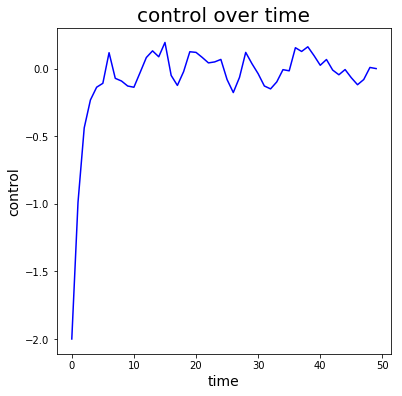

In [5]:
lds_zero.plot_control(a)

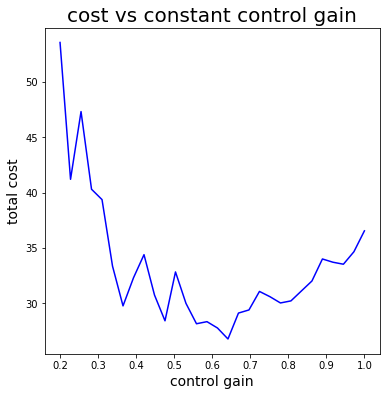

In [6]:
control_gain_array = np.linspace(.2,1,30)
cost_array = np.zeros(control_gain_array.shape)
for i in range(len(control_gain_array)):
    target = np.zeros(T)
    lds_zero = LDS_1D(T, ini_state, noise_var, target)
    L =  np.ones(T) * control_gain_array[i]
    a, x = lds_zero.dynamics_zero_state(D, B, Q, R, L)
    cost_array[i] = lds_zero.cost(a, x, Q, R)

fig, ax = plt.subplots(1, figsize = (6, 6))
ax.plot(control_gain_array, cost_array, 'b')
ax.set_xlabel("control gain", fontsize =14)
ax.set_ylabel("total cost" , fontsize =14)
ax.set_title("cost vs constant control gain", fontsize =20)
plt.show()

In [7]:
np.min(cost_array)

26.777097325125343

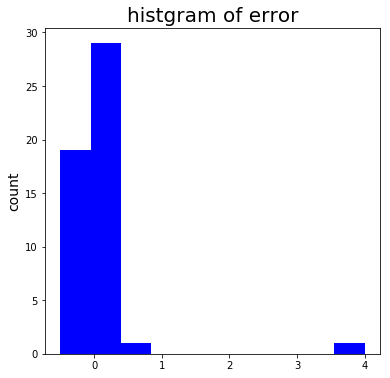

In [8]:
lds_zero.plot_hist(x)

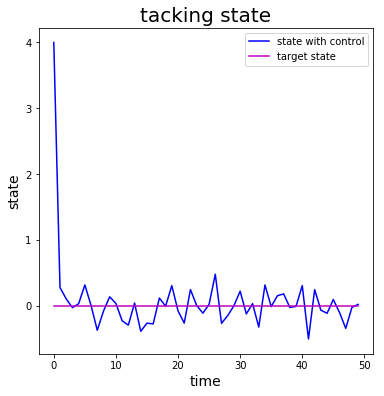

In [9]:
lds_zero.plot_position(x)

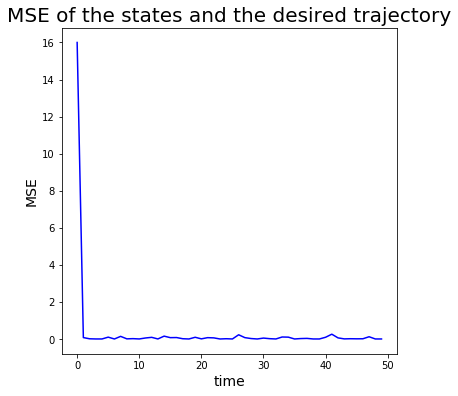

In [10]:
lds_zero.plot_MSE(x)

# LQR

---

## Solving LQR with Dynamic Programming

The solution of LQR can be obtained via Dynamic Programming as follows:
1. set $P_T = Q_T$
2. for $t = T ,...,1$,

    $P_{t-1}  = Q + A^TP_tA - A^TP_tB(R+B^TP_tB)^{-1}B^TP_tA$

3. update the control gain
   
   for $t = T ,...,1$,

    $K^{lqg}_{t-1}  = (R+B^TP_tB)^{-1}B^TP_tA$

4. optimal gain at time $t$ is: $a_t = - K^{lqg}_tx_t$



### Exercise 2: LQR to the origin 

In this exercise, we will design an LQR control for original states, i.e. the state should be zero at all the time. 

** Suggestions **
* We have provided the code in function control_gain( ) for updating *P* iteratively as introduced above. Complete the function to update control gain. Note all the parameters are scalar, and regular math operation should be used instead of numpy matrix operation. 
* Apply the LQR controller, and plot the trajectory of states. 

In [11]:
class LQR_1D(LDS_1D):
    def __init__(self, T, ini_state, noise_var, target):
        super().__init__(T, ini_state, noise_var, target)
    
    
    def control_gain_LQR(self, D, B, Q, R):

        P = np.zeros(self.T) # Riccati updates
        P[-1] = Q  
        
        L = np.zeros(self.T) # control gain 
        
        for t in range(self.T-1):
            P[self.T - t - 2] = (Q + 
                            P[self.T - t - 1] * D **2 - 
                            D * P[self.T - t - 1] * B / (
                                R + P[self.T - t - 1] * B) * B ** 2 * P[self.T - t - 1] * D)

            L[self.T - t - 2] =  (1 / (R + P[self.T - t - 1] * B ** 2) * B * P[self.T - t - 1] * D) 
        
        return L
    

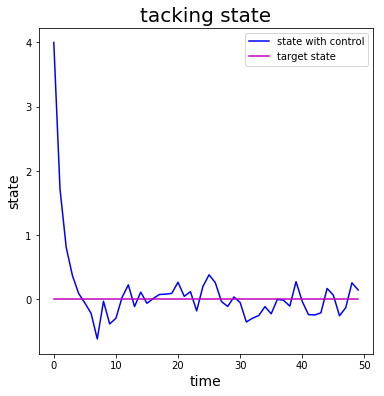

In [12]:
lqr_zero = LQR_1D(T, ini_state, noise_var, target)
L =lqr_zero.control_gain_LQR(D, B, Q, R)
a, x = lds_zero.dynamics_zero_state(D, B, Q, R, L)
lds_zero.plot_position(x)



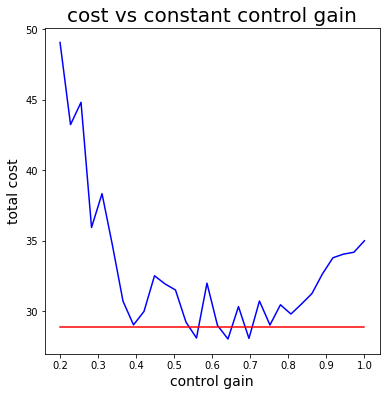

In [13]:
control_gain_array = np.linspace(.2,1,30)
cost_array = np.zeros(control_gain_array.shape)
for i in range(len(control_gain_array)):
    target = np.zeros(T)
    lds_zero = LDS_1D(T, ini_state, noise_var, target)
    L =  np.ones(T) * control_gain_array[i]
    a, x = lds_zero.dynamics_zero_state(D, B, Q, R, L)
    cost_array[i] = lds_zero.cost(a, x, Q, R)
    
    lqr_zero = LQR_1D(T, ini_state, noise_var, target)
    L =lqr_zero.control_gain_LQR(D, B, Q, R)
    a, x = lds_zero.dynamics_zero_state(D, B, Q, R, L)
    c = lds_zero.cost(a, x, Q, R)


fig, ax = plt.subplots(1, figsize = (6, 6))
ax.plot(control_gain_array, cost_array, 'b')
ax.plot(control_gain_array, np.ones(cost_array.shape) * c, 'r')
ax.set_xlabel("control gain", fontsize =14)
ax.set_ylabel("total cost" , fontsize =14)
ax.set_title("cost vs constant control gain", fontsize =20)
plt.show()

## LQR for tracking
When the target state, denoted as $\bar{x}$, is not zero staet, the cost function becomes
$$ J(x, a) = \sum_{t = 0}^{T-1} (Q (x_{t}- \bar{x}_t) ^2 + R (a_{t} - \bar{a}_t))^2 + Q_T (x_{T} - \bar{x}_T) ^2$$,

where $\bar{a}_{t}$ is the desired input, i.e. $\bar{x}_{t+1} = Dx_t + B\bar{a}_{t}$.



### Exercise 3: LQR control to desired target
In this excercise, we will use LQR controller to track sinusoid function. 

** Suggestions **
* In the following code, first generate the target trajectory of sinusoid.
* Complete the code in function `dynamics_tracking( )` to update the control. In fact, the function dynamics_tracking( ) is a general version of the function `dynamcis_zero_state( )` in the first excercise, where the latter case takes zero state as the target, while the former one can take any trajectory as target. 

* Use the provided plotting functions to plot the states over time, the control over time, and the histogram of deviation from the target state.

In [14]:
class LQR_1D_tracking(LQR_1D):
    def __init__(self, T, ini_state, noise_var, target):
        super().__init__(T, ini_state, noise_var, target)
    
    
    def dynamics_tracking(self, D, B, Q, R, L):
        
        x = np.zeros(self.T) # states intialization
        x[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        a = np.zeros(T) # control intialization

        for t in range(self.T - 1):
            a[t] =  - L[t] * (x[t] - self.target[t]) + ( - D * x[t] + self.target[t + 1]) / B
            x[t + 1] = D * x[t] + B * a[t] + noise[t]
        
        return a, x
    

In [15]:
target = np.sin(np.arange(T) * 2 * np.pi * 5 /T)
lqr_sine= LQR_1D_tracking(T, ini_state, noise_var, target)
L =lqr_sine.control_gain_LQR(D, B, Q, R)
a, x = lqr_sine.dynamics_tracking(D, B, Q, R, L)

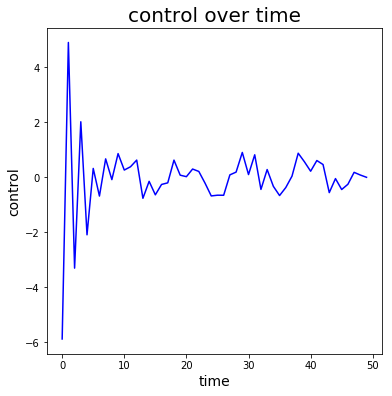

In [16]:
lqr_sine.plot_control(a)

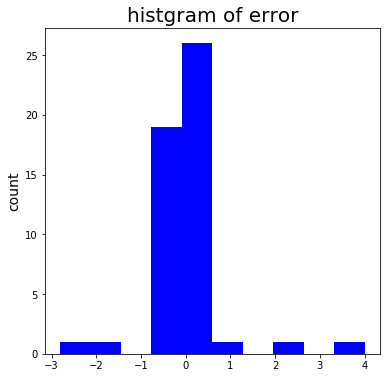

In [17]:
lqr_sine.plot_hist(x)

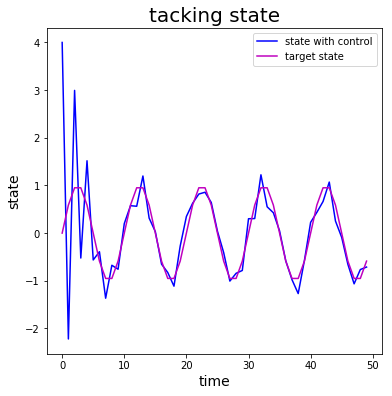

In [18]:
lqr_sine.plot_position(x)

## LQG control of uncertain state with finite time horizon



when the agent is at different site, the observation and the evidence is different. 

stronger evidence gives more discrete beliefs. 

In the previous examples, a target state is provided. However, in practice, one cannot get access to all the state variables. Then there comes the questions: Can we recover the state variables through the measurable information? 

From yesterday's lecture, it is known that the stataes $\hat{x}$ can be estimated with __Kalman filter__. We can replace the control law in LQR, i.e.

$$a_t = - K^{lqg}_tx_t$$

with the estimated states. 

In [19]:
class MyKalmanFilter():
    def __init__(self, n_dim_state, n_dim_obs, transition_matrices, transition_covariance, observation_matrices,
                observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state 
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = transition_matrices #np.eye(n_dim_state)
        self.transition_covariance = transition_covariance #np.eye(n_dim_state) 
        self.observation_matrices = observation_matrices #np.eye(n_dim_obs, n_dim_state)
        self.observation_covariance = observation_covariance #np.eye(n_dim_obs)
        self.initial_state_mean = initial_state_mean #np.zeros(n_dim_state)
        self.initial_state_covariance = initial_state_covariance #np.eye(n_dim_state)
        
        self.control_matrices = control_matrices #np.eye(n_dim_state)
        
    def sample(self, n_timesteps, control_gain, initial_state=None, random_seed=None):
        """
        Method that gives samples
        @param initial_state: numpy array whose length == self.n_dim_state
        @param random_seed: an integer, for test purpose
        @output state: a 2d numpy array with dimension [n_timesteps, self.n_dim_state]
        @output observation: a 2d numpy array with dimension [n_timesteps, self.n_dim_obs]
        """
        # set initial states and seed
        if initial_state is None:
            initial_state = self.initial_state_mean
        if random_seed is not None:
            np.random.seed(random_seed)

        ################
        ##### TODO #####
        ################
        # produce samples
        latent_state = []
        observed_state = []
        current_latent_state = initial_state
        for t in range(n_timesteps):
            
            # for the first latent state is set to the initial state
            if t == 0:
                latent_state.append(current_latent_state)
            # otherwise use transition_matrices and transition_covariance to calculate next latent state
            else:
                #print(current_latent_state)
                ###################LQG#################################
                current_control = - control_gain[t] * current_latent_state
                    
                ###################LQG#################################
                latent_state.append(np.dot(self.transition_matrices, current_latent_state) +
                                    np.dot(self.control_matrices, current_control) + 
                                    np.random.multivariate_normal(np.zeros(self.n_dim_state),
                                                                  self.transition_covariance))
                current_latent_state = latent_state[-1]
                
                
                
            # use observation_matrices and observation_covariance to calculate next observed state
            observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

        #latent_state = np.zeros([n_timesteps, self.n_dim_state])
        #observed_state = np.zeros([n_timesteps, self.n_dim_obs])
        return np.array(latent_state), np.array(observed_state)
    

    def filter(self, X, control_gain, use_myfilter=True):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """

        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim == self.n_dim_obs

        # create holders for outputs
        filtered_state_means = np.zeros([n_example, self.n_dim_state])
        filtered_state_covariances = np.zeros([n_example, self.n_dim_state, self.n_dim_state])

        #############################
        # TODO: implement filtering #
        #############################
        if use_myfilter:
            # the first state mean and state covar is the initial expectation
            filtered_state_means[0] = self.initial_state_mean
            filtered_state_covariances[0] = self.initial_state_covariance

            # initialize internal variables
            current_state_mean = self.initial_state_mean.copy()
            current_state_covar = self.initial_state_covariance.copy()
            self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
            for i in range(1, n_example):
                current_observed_data = X[i, :]
                # run a single step forward filter
                # prediction step
                current_control = - control_gain[i - 1] * current_state_mean
                
                ###################LQG#################################
                predicted_state_mean = np.dot(self.transition_matrices, current_state_mean
                                             ) + np.dot(self.control_matrices, current_control)
                predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),
                                                np.transpose(self.transition_matrices)) + self.transition_covariance
                # observation step
                innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
                innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov),
                                                  np.transpose(self.observation_matrices)) + self.observation_covariance
                # update step
        
     
                kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                                        np.linalg.inv(innovation_covariance))
                current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation) 
                current_state_covar = np.matmul((np.eye(current_state_covar.shape[0]) -
                                                 np.matmul(kalman_gain, self.observation_matrices)),
                                                predicted_state_cov)
                # populate holders
                filtered_state_means[i, :] = current_state_mean
                filtered_state_covariances[i, :, :] = current_state_covar
                self.p_n_list[i, :, :] = predicted_state_cov
                # self.p_n_list[i-1, :, :] = predicted_state_cov
            # new
            # self.p_n_list[-1, :, :] = np.matmul(np.matmul(self.transition_matrices, filtered_state_covariances[-1,:,:]),
            #                                    np.linalg.inv(self.transition_matrices)) + self.transition_covariance

#         else:
#             #################################################################################
#             # below: this is an alternative if you do not have an implementation of filtering
#             kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
#             need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
#                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
#             for param in need_params:
#                 setattr(kf, param, getattr(self, param))
#             filtered_state_means, filtered_state_covariances = kf.filter(X)
#         #################################################################################

        return filtered_state_means, filtered_state_covariances

    def filter_com(self, n_timesteps, control_gain, use_myfilter=True):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """

        # validate inputs
        #n_example, observed_dim = X.shape
        #assert observed_dim == self.n_dim_obs
        
        n_example = n_timesteps
        observed_dim = self.n_dim_obs
        latent_state = []
        observed_state = []
        control = []
        current_latent_state = self.initial_state_mean #initial_state
        control.append(self.initial_state_mean)
        latent_state.append(current_latent_state)
        observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))



        # create holders for outputs
        filtered_state_means = np.zeros([n_example, self.n_dim_state])
        filtered_state_covariances = np.zeros([n_example, self.n_dim_state, self.n_dim_state])

        #############################
        # TODO: implement filtering #
        #############################
        if use_myfilter:
            # the first state mean and state covar is the initial expectation
            filtered_state_means[0] = self.initial_state_mean
            filtered_state_covariances[0] = self.initial_state_covariance

            # initialize internal variables
            current_state_mean = self.initial_state_mean.copy()
            current_state_covar = self.initial_state_covariance.copy()
            self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
            
            for i in range(1, n_example):
                #print(current_latent_state)
                
                ###################LQG#################################
                current_control = - control_gain[i] * current_state_mean
                control.append(current_control)    
                ###################LQG#################################
                
                latent_state.append(np.dot(self.transition_matrices, current_latent_state) +
                                    np.dot(self.control_matrices, current_control) + 
                                    np.random.multivariate_normal(np.zeros(self.n_dim_state),
                                                                  self.transition_covariance))
                current_latent_state = latent_state[-1]
                
                                
                # use observation_matrices and observation_covariance to calculate next observed state
                observed_state.append(np.dot(self.observation_matrices, current_latent_state
                                            ) + np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

                observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

                
                current_observed_data = observed_state[-1]
                # run a single step forward filter
                # prediction step
                #current_control = - control_gain[i - 1] * current_state_mean
                
                ###################LQG#################################
                predicted_state_mean = np.dot(self.transition_matrices, current_state_mean
                                             ) + np.dot(self.control_matrices, current_control)
                predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),
                                                np.transpose(self.transition_matrices)) + self.transition_covariance
                # observation step
                innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
                innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov),
                                                  np.transpose(self.observation_matrices)) + self.observation_covariance
                # update step
        
     
                kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                                        np.linalg.inv(innovation_covariance))
                current_state_mean = predicted_state_mean + np.dot(kalman_gain, innovation) 
                current_state_covar = np.matmul((np.eye(current_state_covar.shape[0]) -
                                                 np.matmul(kalman_gain, self.observation_matrices)),
                                                predicted_state_cov)
                # populate holders
                filtered_state_means[i, :] = current_state_mean
                filtered_state_covariances[i, :, :] = current_state_covar
                self.p_n_list[i, :, :] = predicted_state_cov
                # self.p_n_list[i-1, :, :] = predicted_state_cov
            # new
            # self.p_n_list[-1, :, :] = np.matmul(np.matmul(self.transition_matrices, filtered_state_covariances[-1,:,:]),
            #                                    np.linalg.inv(self.transition_matrices)) + self.transition_covariance

#         else:
#             #################################################################################
#             # below: this is an alternative if you do not have an implementation of filtering
#             kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
#             need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
#                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
#             for param in need_params:
#                 setattr(kf, param, getattr(self, param))
#             filtered_state_means, filtered_state_covariances = kf.filter(X)
#         #################################################################################

        return filtered_state_means, filtered_state_covariances, latent_state, observed_state, control




In [20]:
n_dim_state = 1
n_dim_obs = 1
n_timesteps = 20

transition_matrices = np.eye(n_dim_state)*.9
transition_covariance = np.eye(n_dim_obs) * .1
observation_matrices = np.eye(n_dim_state)
observation_covariance = np.eye(n_dim_obs) * 0.00001
initial_state_mean = np.zeros(n_dim_state)
initial_state_covariance = np.eye(n_dim_state)*.01
control_matrices = np.eye(n_dim_state)

In [21]:
my_kf = MyKalmanFilter(n_dim_state, n_dim_obs, 
                       transition_matrices, transition_covariance, observation_matrices,
                       observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)

In [22]:
control_gain = np.ones(n_timesteps) * .87
filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = my_kf.filter_com(n_timesteps, control_gain)

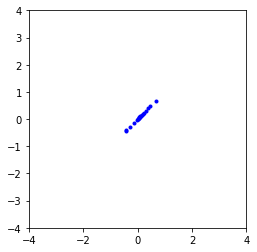

In [23]:
fig, ax = plt.subplots(1, 1)
ax.plot(latent,filtered_state_means_impl, 'b.')
ax.set_aspect('equal')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
plt.show()

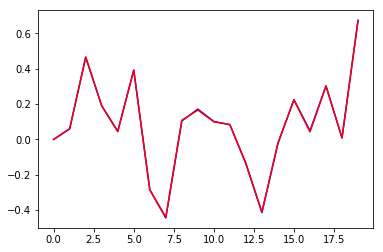

In [24]:
plt.plot(latent, 'b')
plt.plot(filtered_state_means_impl, 'r')

In [25]:
class LQG_1D(MyKalmanFilter, LQR_1D):
    def __init__(self, T, target, n_dim_state, n_dim_obs, 
                 transition_matrices, transition_covariance, observation_matrices,
                 observation_covariance, initial_state_mean, initial_state_covariance, control_matrices):
        MyKalmanFilter.__init__(self,n_dim_state, n_dim_obs, 
                                transition_matrices, transition_covariance, 
                                observation_matrices,observation_covariance, 
                                initial_state_mean, initial_state_covariance, control_matrices)
        LQR_1D.__init__(self,T, initial_state_mean, transition_covariance, target)   

In [26]:
target = np.zeros(n_timesteps)
Q = 10 * np.eye(n_dim_state)   # cost of state
R = 2 * np.eye(n_dim_obs)  # cost of control

lqg = LQG_1D(n_timesteps, target, n_dim_state, n_dim_obs, 
             transition_matrices, transition_covariance, observation_matrices,
             observation_covariance, initial_state_mean, initial_state_covariance, control_matrices)

In [27]:
control_gain_lqg = lqg.control_gain_LQR(transition_matrices, control_matrices, Q, R)
filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
    n_timesteps, control_gain_lqg)

lqg_cost = lqg.cost(latent, control, Q, R)
lqg_cost

7.983892266279158

In [28]:
# cost to go
for i in range(len(latent)):
    print(np.sum(np.square(latent[i:])) * Q + np.sum(np.square(control[i:])) * Q)

[[18.35747947]]
[[18.35747947]]
[[18.30594657]]
[[18.01397687]]
[[17.70144247]]
[[16.94882121]]
[[16.56876433]]
[[16.16605799]]
[[14.31962997]]
[[12.89075996]]
[[11.80511972]]
[[11.14784472]]
[[10.53367342]]
[[10.00932414]]
[[8.07106669]]
[[7.0019553]]
[[5.62592847]]
[[4.30076331]]
[[3.88112522]]
[[1.03065717]]


In [29]:
control_gain_lqg

array([0.76544881, 0.76544881, 0.76544881, 0.76544881, 0.76544881,
       0.76544881, 0.76544881, 0.76544881, 0.76544881, 0.76544881,
       0.76544881, 0.76544881, 0.76544881, 0.76544881, 0.76544881,
       0.76544872, 0.76544373, 0.76516854, 0.75      , 0.        ])

In [30]:
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.
    
    x[k+1] = A x[k] + B u[k]
    
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    #ref Bertsekas, p.151
    
    #first, try to solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    
    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
    
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
    
    return K, P, eigVals

K, P, eigVals = dlqr(transition_matrices, observation_matrices, Q, R)
#u = np.dot(-K, (state - target))  #2x1
K

matrix([[0.76544881]])

In [31]:
# for i in range(20):
#     #L = np.ones(n_timesteps) * 0.5

#     filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
#         n_timesteps, control_gain_lqg)

#     print(lqg.cost(latent, control, Q, R))

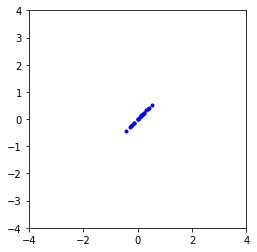

In [32]:
# latent, data = lqg.sample(n_timesteps, L, initial_state=my_kf.initial_state_mean)
# filtered_state_means_impl, filtered_state_covariances_impl = lqg.filter(data, L)
fig, ax = plt.subplots(1, 1)
ax.plot(latent,filtered_state_means_impl, 'b.')
ax.set_aspect('equal')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
plt.show()

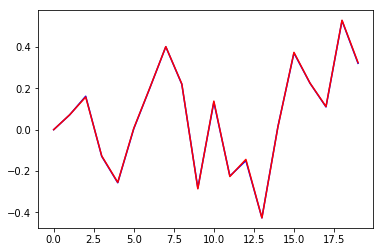

In [33]:
plt.plot(latent, 'b')
plt.plot(filtered_state_means_impl, 'r')

In [34]:
lqg_cost_array = [] 
cost_array_N = []
n_iter = 10

#fig, ax = plt.subplots(1, figsize = (6, 6))
for i in range(n_iter):
    control_gain_array = np.linspace(0.1,1.5,20)
    cost_array = np.zeros(control_gain_array.shape)
    for i in range(len(control_gain_array)):
        control_gain = np.ones(n_timesteps) * control_gain_array[i]
        filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
            n_timesteps, control_gain)
        cost_array[i] = lqg.cost(latent, control, Q, R)
    cost_array_N.append(cost_array)
        
    control_gain_lqg = lqg.control_gain_LQR(transition_matrices, control_matrices, Q, R)
    filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
        n_timesteps, control_gain_lqg)
    lqg_cost = lqg.cost(latent, control, Q, R)
    lqg_cost_array.append(lqg_cost)
    
#     ax.plot(control_gain_array, np.ones(control_gain_array.shape) * lqg_cost, '--')
#     ax.plot(control_gain_array, cost_array, 'b')
#     ax.set_xlabel("control gain", fontsize =16)
#     ax.set_ylabel("total cost" , fontsize =16)
#     ax.set_title("cost vs constant control gain", fontsize =20)
    
#     ax.set_ylim([np.min(cost_array) - 1/10* (np.max(cost_array) - np.min(cost_array)), 
#                  np.max(cost_array) + 1/10* (np.max(cost_array) - np.min(cost_array))])

#     ax1 = ax.twinx()
#     ax1.plot(control_gain_array, lqg_cost_array, '--')
#     ax1.set_ylim([np.min(cost_array) - 1/20* (np.max(cost_array) - np.min(cost_array)), 
#                  np.max(cost_array) + 1/20* (np.max(cost_array) - np.min(cost_array))])
#     ax1.set_yticks([lqg_cost])
#     ax1.tick_params(axis='both', which='major', labelsize=16)
#     labels = [item.get_text() for item in ax1.get_yticklabels()]
#     #labels[0] = 'lqg cost'
#     labels[0] = ''
#     ax1.set_yticklabels(labels)

cost_array_mean = np.mean(np.array(cost_array_N), axis = 0)

cost_array_std = np.std(np.array(cost_array_N), axis = 0)

lqg_cost_mean = np.mean(np.array(lqg_cost_array))
lqg_cost_std = np.std(np.array(lqg_cost_array))

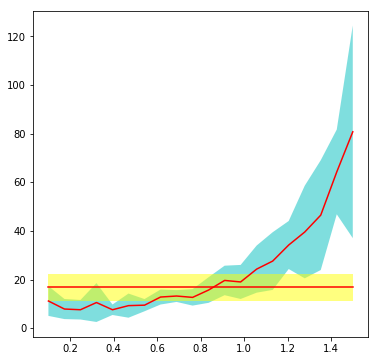

In [35]:
fig, ax = plt.subplots(1, figsize = (6, 6))

ax.plot(control_gain_array, cost_array_mean, 'r-')
ax.fill_between(control_gain_array, cost_array_mean+cost_array_std, 
                cost_array_mean-cost_array_std, facecolor='c', alpha=0.5)


ax.plot(control_gain_array, np.ones(control_gain_array.shape) * lqg_cost_mean, 'r-')
ax.fill_between(control_gain_array, lqg_cost_mean+lqg_cost_std, 
                lqg_cost_mean-lqg_cost_std, facecolor='yellow', alpha=0.5)
plt.show()

In [36]:
# temp = []
# for i in range(2):
#     control_gain = np.ones(n_timesteps) * 0.86966979
#     control_gain[-1] = 0
#     control_gain[-2] = 0.86
# #     control_gain = np.copy(control_gain_lqg)
# #     print(control_gain)
# #     filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
# #         n_timesteps, control_gain)
#     #control_gain_lqg = lqg.control_gain_LQR(transition_matrices, control_matrices, Q, R)
#     #print(control_gain_lqg)
#     filtered_state_means_impl, filtered_state_covariances_impl, latent, data, control = lqg.filter_com(
#         n_timesteps, control_gain)
#     lqg_cost = lqg.cost(latent, control, Q, R)
#     temp.append(lqg.cost(latent, control, Q, R))
    
    
# np.mean(np.array(temp))

In [37]:
#plt.hist(np.array(lqg_cost_array))

In [38]:
# fig, ax = plt.subplots(1, figsize = (6, 6))
# ax.plot(control_gain_array, cost_array, 'b')
# ax.set_xlabel("control gain", fontsize =16)
# ax.set_ylabel("total cost" , fontsize =16)
# ax.set_title("cost vs constant control gain", fontsize =20)
# ax.set_ylim([np.min(cost_array) - 1/20* (np.max(cost_array) - np.min(cost_array)), 
#              np.max(cost_array) + 1/20* (np.max(cost_array) - np.min(cost_array))])

# ax1 = ax.twinx()
# ax1.plot(control_gain_array, lqg_cost_array, 'r--')
# ax1.set_ylim([np.min(cost_array) - 1/20* (np.max(cost_array) - np.min(cost_array)), 
#              np.max(cost_array) + 1/20* (np.max(cost_array) - np.min(cost_array))])
# ax1.set_yticks([lqg_cost])
# ax1.tick_params(axis='both', which='major', labelsize=16)
# labels = [item.get_text() for item in ax1.get_yticklabels()]
# labels[0] = 'lqg cost'
# ax1.set_yticklabels(labels)
# plt.show()